In [1]:
# import the necessary packages
import import_ipynb
import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
from imutils import paths
from skimage.io import imread, imshow
from scipy.ndimage.filters import gaussian_filter

importing Jupyter notebook from config.ipynb


In [2]:
def fix_patch(patch, val):
    patch_tmp = np.where(patch == val, patch, 0)
    blurred_patch = gaussian_filter(patch_tmp, sigma=0.7)
    patch_tmp = np.where((blurred_patch < int(0.9 * val)) & (blurred_patch > int(0.5 * val)), 0, 1)
    return patch * patch_tmp


def smart_matrix_indexing(r_min, r_max, c_min, c_max, mat):
    row_max, col_max = np.subtract(mat.shape, (1, 1))
    r_min = np.max([r_min - 3, 0])
    r_max = np.min([r_max + 3, row_max])
    c_min = np.max([c_min - 3, 0])
    c_max = np.min([c_max + 3, col_max])
    return r_min, r_max, c_min, c_max


def fix_segmentation_maps(mask):
    unique_values = np.unique(mask)
    unique_values = unique_values[np.where(unique_values > 0)]
    for val in unique_values:
        r, c = np.where(mask == val)
        r_min, r_max, c_min, c_max = smart_matrix_indexing(r.min(), r.max(), c.min(), c.max(), mask)
        patch = mask[r_min:r_max, c_min:c_max]
        mask[r_min:r_max, c_min:c_max] = fix_patch(patch, val)
    return mask

In [3]:
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [4]:
def make_predictions(model, imagePath, gtPath, test, pred, gt):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH))
        orig = image.copy()
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = imread(gtPath)
        gtMask = gtMask.astype(np.uint8)
        #binaryfication of gt masks
        fixed_mask = fix_segmentation_maps(gtMask)
        for i in range(len(gtMask)):
            for j in range(len(gtMask[i])):
                if(gtMask[i][j] != 0):
                    gtMask[i][j] = 255
                else:
                    gtMask[i][j]=0
        #gt_copy = gtMask.copy()
        #bin_mask(gtMask,gt_copy)
        gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
            config.INPUT_IMAGE_HEIGHT))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(config.DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        test.append(orig)
        pred.append(predMask)
        gt.append(gtMask)
        #predMask = (predMask > config.THRESHOLD) * 255
        #predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        #prepare_plot(orig, gtMask, predMask)
        #cellpose_test.append(predMask)

In [5]:
# load the image paths in our testing file and randomly select 10
# image paths
cellpose_test=[]
cellpose_pred=[]
cellpose_gt=[]

print("[INFO] loading up test image paths...")
test_path = os.path.join(config.DATASET_PATH, "test_img")
gt_path = os.path.join(config.DATASET_PATH, "test_masks")
imagePaths = sorted(list(paths.list_images(test_path)))
gtPaths = sorted(list(paths.list_images(gt_path)))
length = len(imagePaths)
#imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
for i in range(length):
	# make predictions and visualize the results
	make_predictions(unet, imagePaths[i],gtPaths[i], cellpose_test, cellpose_pred, cellpose_gt)
    #prepare_plot(imagePaths[i], gtPaths[i],gtPaths[i])

[INFO] loading up test image paths...
[INFO] load up model...
importing Jupyter notebook from model.ipynb


In [6]:
len(cellpose_test)

68

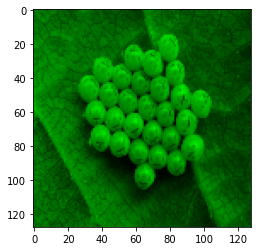

In [7]:
plt.imshow(cellpose_test[67])

<ipython-input-3-a21df97777e1>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


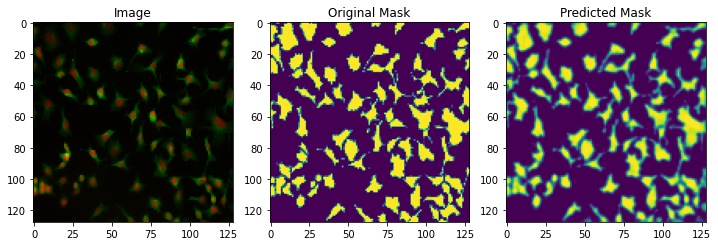

In [8]:
prepare_plot(cellpose_test[0], cellpose_gt[0], cellpose_pred[0])

<ipython-input-3-a21df97777e1>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


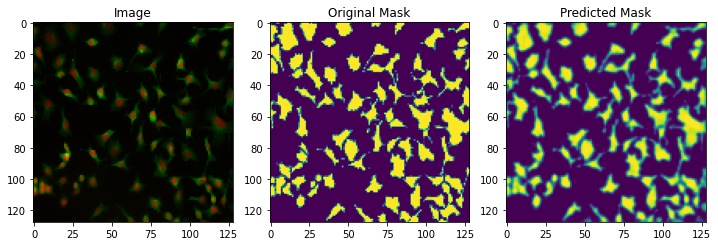

In [9]:
prepare_plot(cellpose_test[0], cellpose_gt[0], cellpose_pred[0])

In [10]:
def iouScore(Y, Y1, threshold):
    Y2 = Y1 > threshold
    intersection = np.logical_and(Y, Y2)
    union = np.logical_or(Y, Y2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [11]:
def avg_iou(Y, Y1, threshold):
    siou = 0;
    for i in range(len(Y)):
        siou += iouScore(Y[i], Y1[i], threshold)
    iou = siou/len(Y)
    return iou

In [12]:
x = [i for i in np.arange(0,1,0.0001)]

In [13]:
ious=[]
for i in x:
    ious.append(avg_iou(cellpose_gt, cellpose_pred, i))

In [78]:
iou1 = os.path.sep.join([config.BASE_OUTPUT, "iou_test_150.png"])
iou2 = os.path.sep.join([config.BASE_OUTPUT, "iou_train_150.png"])

No handles with labels found to put in legend.


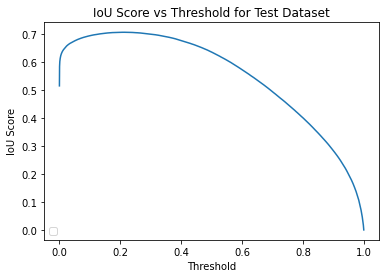

In [79]:
plt.plot(x,ious)
plt.title("IoU Score vs Threshold for Test Dataset")
plt.xlabel("Threshold")
plt.ylabel("IoU Score")
plt.legend(loc="lower left")
plt.savefig(iou1)

In [15]:
ious.index(max(ious))

2114

In [16]:
x[2114]

0.2114

In [17]:
# load the image paths in our testing file and randomly select 10
# image paths
cellpose_train=[]
cellpose_pred_tr=[]
cellpose_gt_tr=[]

print("[INFO] loading up test image paths...")
test_path = os.path.join(config.DATASET_PATH, "train_img")
gt_path = os.path.join(config.DATASET_PATH, "train_masks")
imagePaths = sorted(list(paths.list_images(test_path)))
gtPaths = sorted(list(paths.list_images(gt_path)))
length = len(imagePaths)
#imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
for i in range(length):
	# make predictions and visualize the results
	make_predictions(unet, imagePaths[i],gtPaths[i], cellpose_train, cellpose_pred_tr, cellpose_gt_tr)

[INFO] loading up test image paths...
[INFO] load up model...


In [18]:
ious_tr=[]
for i in x:
    ious_tr.append(avg_iou(cellpose_gt_tr, cellpose_pred_tr, i))

In [157]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "x={:.3f}\ny={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=2,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="bottom")
    ax.annotate(text, xy=(xmax, ymax), **kw)

def annot_max1(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "x={:.3f}\ny={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=170")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="bottom")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.8), **kw)

<ipython-input-157-b7a3aa8083f7>:11: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(text, xy=(xmax, ymax), **kw)


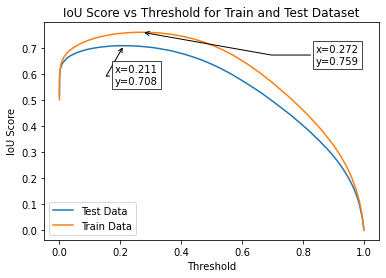

In [159]:
plt.plot(x,ious, label = "Test Data")
annot_max(x,ious)
plt.plot(x,ious_tr, label = "Train Data")
annot_max1(x,ious_tr)
plt.title("IoU Score vs Threshold for Train and Test Dataset")
plt.xlabel("Threshold")
plt.ylabel("IoU Score")
plt.legend(loc="lower left")
plt.savefig(iou2)
plt.show()

In [20]:
ious_tr.index(max(ious_tr))

2717

In [21]:
x[2717]

0.2717

In [22]:
max(ious)

0.7077528570920243

In [23]:
max(ious_tr)

0.7590636164684007

In [ ]:
prepare_plot(cellpose_test[0], cellpose_gt[0], cellpose_pred[0])

In [61]:
y = cellpose_pred[0] > 0.4

<ipython-input-3-a21df97777e1>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


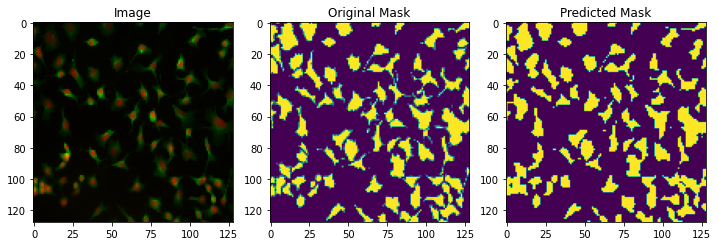

In [62]:
prepare_plot(cellpose_test[0], cellpose_gt[0], y)

In [70]:
import random

<ipython-input-3-a21df97777e1>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


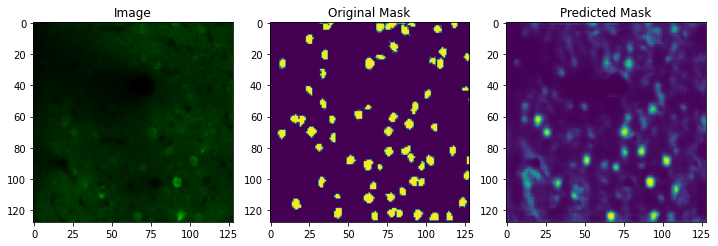

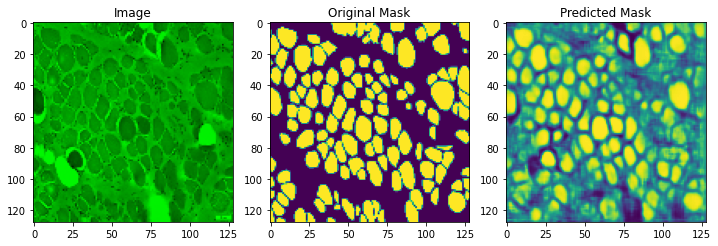

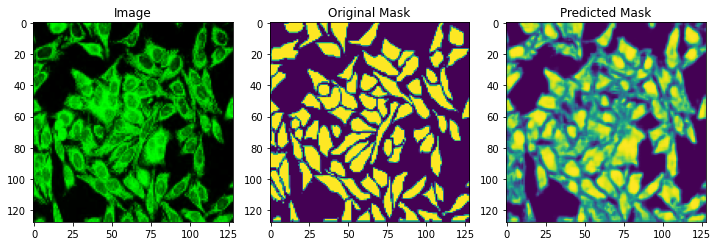

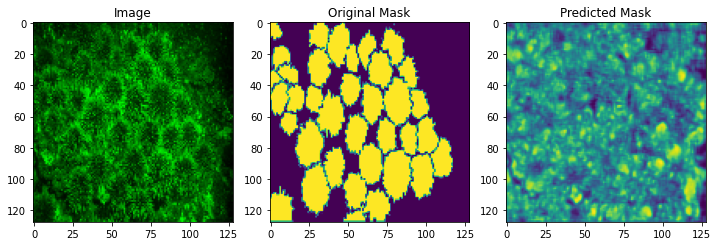

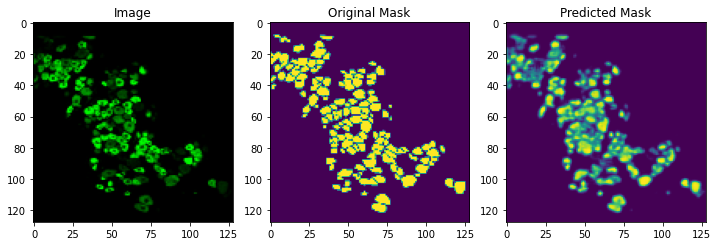

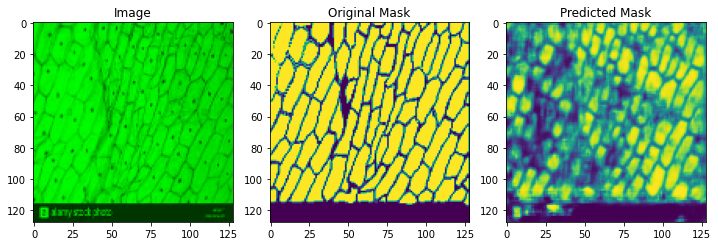

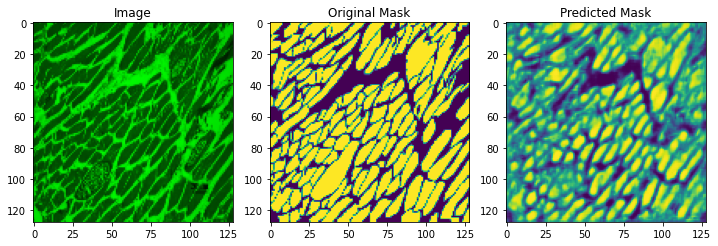

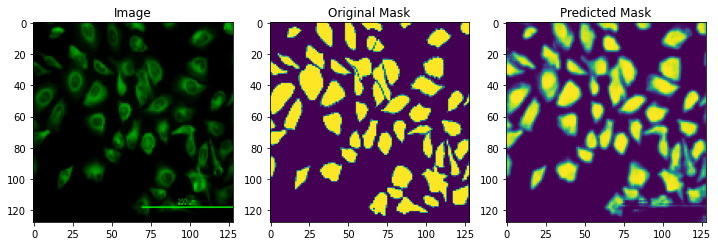

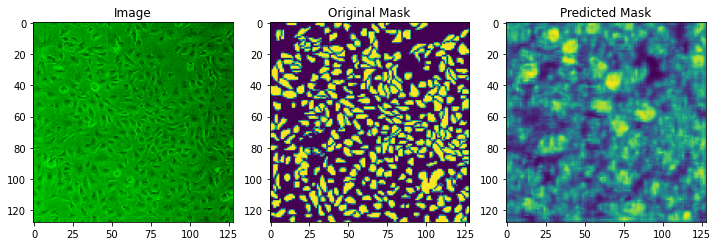

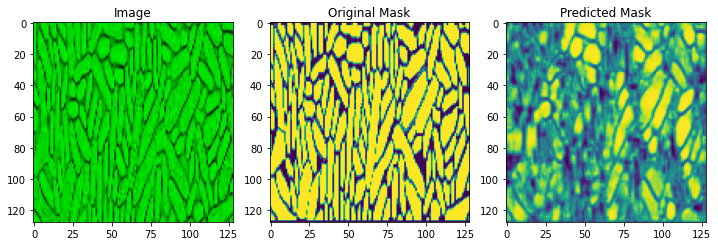

In [76]:
for index in range(10):
    i = random.randint(0,len(cellpose_test))
    prepare_plot(cellpose_test[i], cellpose_gt[i], cellpose_pred[i])

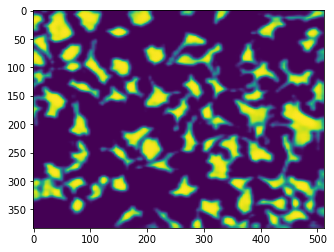